**This is the project file of "Analyzing student activity in the Computer Programming course"**

Description:
During the semester there were 16 quizzes and 13 programming homework
assignments. Typically, there was one quiz and one homework every week,
but on weeks 6, 12, and 16 there was no homework. Both the quizzes and
the homeworks were graded automatically and the students could
immediately submit a new attempt if they wished. The number of attempts
was not limited.

The file data.csv contains the numbers of attempts in quizzes and
homeworks and has the following columns.

* Student: Student code (S001 through S467)
* Gender: M for male, F for female
* Skill level: Self-reported skill level in the start survey at the
beginning of the course (Novice, Beginner, Intermediate, Proficient,
Expert); a "-" means that the student did not respond to the start
survey
* Numbers of attempts the student made in quizzes (weeks 1-16)
* Numbers of attempts the student made in homeworks (weeks 1-5, 7-11,
13-15)
* Score: Final score of the course
* Grade: Final grade

The file log.csv contains the times and scores of all attempts and has
the following columns.

* Day: Day number, where the first Monday of the semester is day 1.
* Time: The time when a quiz attempt was started or a homework was
uploaded
* Student: Student code (S001 throught S467), which is the same as the
student code in the file data.csv
* Activity: The name of the activity (quiz or homework) and the week
number
* Score: The automatic grade of the activity on a scale of 0-0.5, with
two decimal places

For quizzes, the score 0 often means that the student simply opened the
quiz to see what the questions were, without trying to answer them, and
made a real attempt later. The score "-" in the quizzes means that the
student started the quiz attempt but did not submit it at the end. The
score "-" in the homeworks means that the student uploaded the files but
didn't submit them for automatic grading. All activities had deadlines
but the quizzes were reopened in practice mode sometime after the
deadline, to help prepare for the exams.

The deadlines for the quizzes and homeworks were Thursday 8:00 each
week, except for Week 1, when the deadline was Sunday 23:59. On
Thursdays, there were in-class activities and the quizzes and homeworks
of the following week opened on Thursday at 18:00.

In addition to quizzes and homework assignments, there were other
learning activities (exams, midterms, course project, etc.) not included
in the data set. The final grade was calculated based on the final score
of all activities: A>=90, B>=80, C>=70, D>=60, E>=50, F<50. Some course
activities had a threshold that had to be passed to pass the course, so
some students with a score above 50 still received an F. The score range
was 0-110 (including 10 bonus points). If the student did not
participate at all, the final score is "-".

At the beginning of the second week, a pre-exam was organized for those
who thought they knew the subject very well. Those students who got at
least 90 points in it, received an A and finished the course straight
away. So the results of students whose final grade is A and who did not
submit any homeworks from week 3 onwards, can be discarded (though some
of these students may have tried some later quizzes for fun).

For a machine learning model, you can use either of the provided data
files, or you can use both. All of these options are good.

Open the files:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [2]:
uploaded = files.upload()
!ls

Saving data-2021.csv to data-2021.csv
data-2021.csv  data.csv  sample_data


In [3]:
uploaded2 = files.upload()
!ls

Saving log.csv to log.csv
data-2021.csv  data.csv  log.csv  sample_data


In [4]:
uploaded3 = files.upload()
!ls

Saving log-2021.csv to log-2021.csv
data-2021.csv  data.csv  log-2021.csv  log.csv	sample_data


In [5]:
#important Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Create dataframes of the data we uploaded

In [61]:
#first look at the datasets
student_data = pd.read_csv('data.csv')
test_logs = pd.read_csv('log.csv')

#2021 data
student_data_2021 = pd.read_csv('data-2021.csv')
test_logs_2021 = pd.read_csv('log-2021.csv')



student_data.head()

,Student,Gender,Skill level,Week 1 quiz,Week 2 quiz,Week 3 quiz,Week 4 quiz,Week 5 quiz,Week 6 quiz,Week 7 quiz,...,Week 7 homework,Week 8 homework,Week 9 homework,Week 10 homework,Week 11 homework,Week 13 homework,Week 14 homework,Week 15 homework,Score,Grade
0,S001,F,Novice,7,2,4,7,9,6,5,...,6,2,16,2,2,6,1,3,82.4,B
1,S002,M,Proficient,3,3,1,1,1,1,1,...,4,1,4,7,1,5,1,6,93,A
2,S003,F,Novice,1,3,5,1,3,1,1,...,2,6,7,4,4,2,3,2,74.9,C
3,S004,M,Proficient,1,1,3,2,4,1,1,...,4,3,1,7,1,6,2,1,98.9,A
4,S005,F,Novice,1,2,3,1,3,3,2,...,3,2,5,2,39,6,1,6,87.12,B


In [62]:
test_logs.head()

,Day,Time,Student,Activity,Score
0,1,09:43:47,S124,Week 1 homework,0.0
1,1,09:44:28,S124,Week 1 homework,0.26
2,1,09:45:43,S124,Week 1 homework,0.5
3,1,13:21:00,S248,Week 1 quiz,0.28
4,1,14:57:17,S261,Week 1 quiz,0.44


In [63]:
#We throw out students who performed the early exam to pass the course
#For that we throw out students who got the grade 'A' and who had more than 20
#unattempted tests.
columns_to_check = list()
for i in range(1,17):
  columns_to_check.append(f"Week {i} quiz")
  if i != 6 and i != 12 and i != 16:
    columns_to_check.append(f"Week {i} homework")

count_per_row = (student_data[columns_to_check] == 0).sum(axis=1)
students_with_i_tests_zero = list()
for i in range(30):
  students_with_i_tests_zero.append((count_per_row >= i).sum())

count_rows_more_than_20 = (count_per_row >= 5).sum()
student_data['zero_attempts_count'] = count_per_row
student_data_new = student_data.loc[~((student_data['zero_attempts_count']> 20) & (student_data['Grade'] == 'A'))]



count_per_row_2021 = (student_data_2021[columns_to_check] == 0).sum(axis=1)
students_with_i_tests_zero_2021 = list()
for i in range(30):
  students_with_i_tests_zero_2021.append((count_per_row_2021 >= i).sum())

count_rows_more_than_20_2021 = (count_per_row_2021 >= 5).sum()
student_data_2021['zero_attempts_count'] = count_per_row_2021
student_data_new_2021 = student_data_2021.loc[~((student_data_2021['zero_attempts_count']> 20) & (student_data_2021['Grade'] == 'A'))]





In [66]:
# Here, people who make more than one test have done many tests.
def many_or_few_attempts(row):
  axis_point = 1
  list_of_columns_to_check = list()
  for i in range(1,17):
    list_of_columns_to_check.append(f"Week {i} quiz")
    if i != 6 and i != 12 and i != 16:
      list_of_columns_to_check.append(f"Week {i} homework")
  few_attempts = 0
  many_attempts = 0

  for column in list_of_columns_to_check:
    if row[column] > axis_point:
      many_attempts += 1
    else:
      few_attempts += 1


  if few_attempts > many_attempts:
    return 'few attempts'
  return 'many attempts'


student_data_new['test profile'] = student_data_new.apply(many_or_few_attempts, axis=1)
profile_counts = student_data_new['test profile'].value_counts()

print("Counts of each category:")
print(profile_counts)

Counts of each category:
many attempts    226
few attempts     207
Name: test profile, dtype: int64


<ipython-input-66-c60295a2a1bd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data_new['test profile'] = student_data_new.apply(many_or_few_attempts, axis=1)


In [68]:
from datetime import datetime

def time_string_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M:%S')
    seconds = time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    return seconds

def time_before_dealine(row):
  #the deadline day of the different activities
  deadlines = {
    'Week 1 quiz': 7, 'Week 1 homework': 7,
    'Week 2 quiz': 11, 'Week 2 homework': 11,
    'Week 3 quiz': 18, 'Week 3 homework': 18,
    'Week 4 quiz': 25, 'Week 4 homework': 25,
    'Week 5 quiz': 32, 'Week 5 homework': 32,
    'Week 6 quiz': 39,
    'Week 7 quiz': 46, 'Week 7 homework': 46,
    'Week 8 quiz': 53, 'Week 8 homework': 53,
    'Week 9 quiz': 60, 'Week 9 homework': 60,
    'Week 10 quiz': 67, 'Week 10 homework': 67,
    'Week 11 quiz': 74, 'Week 11 homework': 74,
    'Week 12 quiz': 81,
    'Week 13 quiz': 88, 'Week 13 homework': 88,
    'Week 14 quiz': 95, 'Week 14 homework': 95,
    'Week 15 quiz': 102, 'Week 15 homework': 102,
    'Week 16 quiz': 109
  }

  time_in_seconds = time_string_to_seconds(row['Time'])

  #the first deadline was on a different time
  if row['Activity'] == 'Week 1 quiz' or row['Activity'] == 'Week 1 homework':
    return (deadlines[row['Activity']]-row['Day'])*24*60*60 + 24*60*60-1-time_in_seconds
  return (deadlines[row['Activity']]-row['Day'])*24*60*60 + 8*60*60-time_in_seconds

test_logs['Seconds before deadline'] = test_logs.apply(time_before_dealine, axis=1)

test_logs

,Day,Time,Student,Activity,Score,Seconds before deadline
0,1,09:43:47,S124,Week 1 homework,0.0,569772
1,1,09:44:28,S124,Week 1 homework,0.26,569731
2,1,09:45:43,S124,Week 1 homework,0.5,569656
3,1,13:21:00,S248,Week 1 quiz,0.28,556739
4,1,14:57:17,S261,Week 1 quiz,0.44,550962
...,...,...,...,...,...,...
31986,150,11:31:18,S006,Week 15 quiz,0.49,-4159878
31987,150,11:42:56,S006,Week 16 quiz,-,-3555776
31988,150,12:06:06,S013,Week 9 quiz,-,-7790766
31989,150,12:14:09,S157,Week 8 quiz,-,-8396049


In [77]:
def log_mod_for_time(log,columns,method):
  log.drop(log[log['Score'] == '-'].index, inplace=True)
  log = log.reset_index().groupby(['Student', 'Activity'])['Seconds before deadline'].aggregate(method).unstack()
  log.fillna(value=0, inplace=True)
  log = log.reset_index()
  return log

In [76]:
#Method to determine who started their activity before or after 24 hours of the deadline
def early_or_late_test_starter(row):
  base_time = 60*60*24
  list_of_columns_to_check = list()
  for i in range(1,17):
    list_of_columns_to_check.append(f"Week {i} quiz")
    if i != 6 and i != 12 and i != 16:
      list_of_columns_to_check.append(f"Week {i} homework")
  late = 0
  early = 0

  for column in list_of_columns_to_check:
    if row[column] > base_time:
      early += 1
    else:
      late += 1

  if late > early:
    return 'late'
  return 'early'


modified_log = log_mod_for_time(test_logs, test_logs.columns, 'max')
modified_log['early or late'] = modified_log.apply(early_or_late_test_starter, axis=1)
time_counts = modified_log['early or late'].value_counts()

print("Counts of each category:")
print(time_counts)

Counts of each category:
late     280
early    172
Name: early or late, dtype: int64


In [79]:
#Time before deadline in 4 classes
def test_start_times(row):
  time_1 = 60*60*24
  time_2 = 60*60*16
  time_3 = 60*60*8
  list_of_columns_to_check = list()
  for i in range(1,17):
    list_of_columns_to_check.append(f"Week {i} quiz")
    if i != 6 and i != 12 and i != 16:
      list_of_columns_to_check.append(f"Week {i} homework")

  before_24_hours = 0
  _16_to_24 = 0
  _8_to_16 = 0
  _0_to_8 = 0


  for column in list_of_columns_to_check:
    #if row[column] == 0:
    #  continue
    if row[column] > time_1:
      before_24_hours += 1
    elif row[column] > time_2:
      _16_to_24 += 1
    elif row[column] > time_3:
      _8_to_16 += 1
    else:
      _0_to_8 += 1

  testlist = [before_24_hours, _16_to_24, _8_to_16, _0_to_8]

  maximum = max(testlist)

  if testlist.index(maximum) == 0:
    return 'before 24 hours'
  elif testlist.index(maximum) == 1:
    return '16 to 24'
  elif testlist.index(maximum) == 2:
    return '8 to 16'
  return '0 to 8'


In [104]:
test_logs['Seconds before deadline'] = test_logs.apply(time_before_dealine, axis=1)
modified_log_2 = log_mod_for_time(test_logs, test_logs.columns, 'max')
modified_log_2['time of first test'] = modified_log_2.apply(test_start_times, axis=1)
time_counts_2 = modified_log_2['time of first test'].value_counts()

print("Counts of each category:")
print(time_counts_2)

Counts of each category:
before 24 hours    224
0 to 8             132
8 to 16             83
16 to 24            13
Name: time of first test, dtype: int64


In [82]:
#Method to find out who did tests after a deadline
def did_tests_after_deadline(row):
  list_of_columns_to_check = list()
  for i in range(1,17):
    list_of_columns_to_check.append(f"Week {i} quiz")
    if i != 6 and i != 12 and i != 16:
      list_of_columns_to_check.append(f"Week {i} homework")
  late = 0
  early = 0

  for column in list_of_columns_to_check:
    if row[column] < 0:
      return 'yes'
  return 'no'


late_tests = log_mod_for_time(test_logs, test_logs.columns, 'min')
late_tests['Did late tests'] = late_tests.apply(did_tests_after_deadline, axis=1)
late_counts = late_tests['Did late tests'].value_counts()

print("Counts of each category:")
print(late_counts)

Counts of each category:
no     316
yes    136
Name: Did late tests, dtype: int64


In [87]:
#method that gets a certain score for each student, depending on the method (max, min etc)
def log_mod(log,columns,method):
    day=7
    log=log.drop(log[(log['Activity'] == 'Week 1 quiz') & (log['Day'] > day)].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 quiz') & (log['Day'] == day) & (log['Time'] > '23:59')].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 homework') & (log['Day'] > day)].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 homework') & (log['Day'] == day) & (log['Time'] > '23:59')].index)
    day=11
    for i in range(2,17):
        homework = 'Week '+str(i)+' homework'
        quiz='Week '+str(i)+' quiz'
        day += 7
        if quiz in columns:
            log=log.drop(log[(log['Activity'] == quiz) & (log['Day'] > day)].index)
            log=log.drop(log[(log['Activity'] == quiz) & (log['Day'] == day) & (log['Time'] > '08:00')].index)
        if homework in columns:
            log=log.drop(log[(log['Activity'] == homework) & (log['Day'] > day)].index)
            log=log.drop(log[(log['Activity'] == homework) & (log['Day'] == day) & (log['Time'] > '08:00')].index)
    log.drop(log[log['Score'] == '-'].index, inplace=True)
    log['Score'] = log['Score'].astype(float)
    log = log.reset_index().groupby(['Student', 'Activity'])['Score'].aggregate(method).unstack()
    log.fillna(value=0, inplace=True)
    log = log.rename(columns={'Week 1 homework': f'Week 1 homework score', 'Week 1 quiz': f'Week 1 quiz score',
                              'Week 2 homework': f'Week 2 homework score', 'Week 2 quiz': f'Week 2 quiz score',
                              'Week 3 homework': f'Week 3 homework score', 'Week 3 quiz': f'Week 3 quiz score',
                              'Week 4 homework': f'Week 4 homework score', 'Week 4 quiz': f'Week 4 quiz score',
                              'Week 5 homework': f'Week 5 homework score', 'Week 5 quiz': f'Week 5 quiz score',
                              'Week 6 quiz': f'Week 6 quiz score',
                              'Week 7 homework': f'Week 7 homework score', 'Week 7 quiz': f'Week 7 quiz score',
                              'Week 8 homework': f'Week 8 homework score', 'Week 8 quiz': f'Week 8 quiz score',
                              'Week 9 homework': f'Week 9 homework score', 'Week 9 quiz': f'Week 9 quiz score',
                              'Week 10 homework': f'Week 10 homework score', 'Week 10 quiz': f'Week 10 quiz score',
                              'Week 11 homework': f'Week 11 homework score', 'Week 11 quiz': f'Week 11 quiz score',
                              'Week 12 quiz': f'Week 12 quiz score',
                              'Week 13 homework': f'Week 13 homework score', 'Week 13 quiz': f'Week 13 quiz score',
                              'Week 14 homework': f'Week 14 homework score', 'Week 14 quiz': f'Week 14 quiz score',
                              'Week 15 homework': f'Week 15 homework score', 'Week 15 quiz': f'Week 15 quiz score',
                              'Week 16 quiz': f'Week 16 quiz score'})
    log = log.reset_index()
    return log

In [89]:
#Method that designates people who did thoughtless tests (just opened and then closed the activity)
#we just determine, if for some tests the difference between the best score and average score is above a certain value
def thoughtless_tests(row):
  axis_point = 0.2
  list_of_columns_to_check = list()
  for i in range(1,17):
    list_of_columns_to_check.append(f"Week {i} quiz score")
    if i != 6 and i != 12 and i != 16:
      list_of_columns_to_check.append(f"Week {i} homework score")
  thoughtless = 0

  for column in list_of_columns_to_check:
    if row[column] > axis_point:
      thoughtless += 1

    if thoughtless > 3: # chosesn arbitrarily
      return 'did'
  return 'did not'



In [90]:
best_scores = log_mod(test_logs, test_logs.columns, 'max')
worst_scores = log_mod(test_logs, test_logs.columns, 'min')
average_scores = log_mod(test_logs, test_logs.columns, 'mean')

students = best_scores['Student']


In [91]:
best_and_average_scores_difference = best_scores.drop(['Student'],axis=1)-average_scores.drop(['Student'],axis=1)

best_and_average_scores_difference['Student'] = students

best_and_average_scores_difference['thoughtless_tests'] = best_and_average_scores_difference.apply(thoughtless_tests, axis=1)

thoughtless_test_counts = best_and_average_scores_difference['thoughtless_tests'].value_counts()

print("Counts of each category:")
print(thoughtless_test_counts)


Counts of each category:
did not    400
did         52
Name: thoughtless_tests, dtype: int64


In [110]:
#find the same info for 2021 file
student_data_new_2021['test profile'] = student_data_new_2021.apply(many_or_few_attempts, axis=1)
profile_counts_2021 = student_data_new_2021['test profile'].value_counts()
print("Counts of each category:")
print(profile_counts_2021)



test_logs_2021['Seconds before deadline'] = test_logs_2021.apply(time_before_dealine, axis=1)



modified_log_2021 = log_mod_for_time(test_logs_2021, test_logs_2021.columns, 'max')
modified_log_2021['early or late'] = modified_log_2021.apply(early_or_late_test_starter, axis=1)
time_counts_2021 = modified_log_2021['early or late'].value_counts()
print("Counts of each category:")
print(time_counts_2021)


modified_log_2_2021 = log_mod_for_time(test_logs_2021, test_logs_2021.columns, 'max')
modified_log_2_2021['time of first test'] = modified_log_2_2021.apply(test_start_times, axis=1)
time_counts_2_2021 = modified_log_2_2021['time of first test'].value_counts()
print("Counts of each category:")
print(time_counts_2_2021)


late_tests_2021 = log_mod_for_time(test_logs_2021, test_logs_2021.columns, 'min')
late_tests_2021['Did late tests'] = late_tests_2021.apply(did_tests_after_deadline, axis=1)
late_counts_2021 = late_tests_2021['Did late tests'].value_counts()
print("Counts of each category:")
print(late_counts_2021)



best_scores_2021 = log_mod(test_logs_2021, test_logs_2021.columns, 'max')
average_scores_2021 = log_mod(test_logs_2021, test_logs_2021.columns, 'mean')
students_2021 = best_scores_2021['Student']



best_and_average_scores_difference_2021 = best_scores_2021.drop(['Student'],axis=1)-average_scores_2021.drop(['Student'],axis=1)
best_and_average_scores_difference_2021['Student'] = students_2021
best_and_average_scores_difference_2021['thoughtless_tests'] = best_and_average_scores_difference_2021.apply(thoughtless_tests, axis=1)
thoughtless_test_counts_2021 = best_and_average_scores_difference_2021['thoughtless_tests'].value_counts()
print("Counts of each category:")
print(thoughtless_test_counts_2021)

<ipython-input-110-5b34af5036d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data_new_2021['test profile'] = student_data_new_2021.apply(many_or_few_attempts, axis=1)


Counts of each category:
few attempts     187
many attempts    175
Name: test profile, dtype: int64
Counts of each category:
late     257
early    124
Name: early or late, dtype: int64
Counts of each category:
before 24 hours    191
0 to 8             114
8 to 16             75
16 to 24             1
Name: time of first test, dtype: int64
Counts of each category:
no     295
yes     86
Name: Did late tests, dtype: int64
Counts of each category:
did not    338
did         43
Name: thoughtless_tests, dtype: int64


In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

decision_tree_test_amounts = RandomForestClassifier()
decision_tree_test_amounts.fit(student_data_new[columns_to_check], student_data_new[['test profile']])
tests = decision_tree_test_amounts.predict(student_data_new_2021[columns_to_check])
unique_elements, counts = np.unique(tests , return_counts=True)
result_dict = dict(zip(unique_elements, counts))
print(result_dict)
print(accuracy_score(tests, student_data_new_2021[['test profile']]))


<ipython-input-170-e4250b8a222d>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  decision_tree_test_amounts.fit(student_data_new[columns_to_check], student_data_new[['test profile']])


{'few attempts': 193, 'many attempts': 169}
0.9392265193370166


In [158]:
list_of_columns_to_check = list()
for i in range(1,17):
  list_of_columns_to_check.append(f"Week {i} quiz score")
  if i != 6 and i != 12 and i != 16:
    list_of_columns_to_check.append(f"Week {i} homework score")

In [169]:
decision_tree_early_or_late = GradientBoostingClassifier()
decision_tree_early_or_late.fit(modified_log[columns_to_check], modified_log[['early or late']])
early_or_late = decision_tree_early_or_late.predict(modified_log_2021[columns_to_check])

unique_elements, counts = np.unique(early_or_late , return_counts=True)
result_dict = dict(zip(unique_elements, counts))
print(result_dict)
print(accuracy_score(early_or_late, modified_log_2021[['early or late']]))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'early': 120, 'late': 261}
0.937007874015748


In [153]:
decision_tree_early_or_late = GradientBoostingClassifier()
decision_tree_early_or_late.fit(modified_log_2[columns_to_check], modified_log_2[['time of first test']])
early_or_late_2 = decision_tree_early_or_late.predict(modified_log_2_2021[columns_to_check])

unique_elements, counts = np.unique(early_or_late_2 , return_counts=True)
result_dict = dict(zip(unique_elements, counts))
print(result_dict)
print(accuracy_score(early_or_late_2, modified_log_2_2021[['time of first test']]))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'0 to 8': 111, '8 to 16': 71, 'before 24 hours': 199}
0.8766404199475065


In [174]:
decision_tree_after_deadline = DecisionTreeClassifier()
decision_tree_after_deadline.fit(late_tests[columns_to_check], late_tests[['Did late tests']])
after_deadline = decision_tree_after_deadline.predict(late_tests_2021[columns_to_check])
unique_elements, counts = np.unique(after_deadline , return_counts=True)
result_dict = dict(zip(unique_elements, counts))
print(result_dict)
print(accuracy_score(after_deadline , late_tests_2021[['Did late tests']]))

{'no': 302, 'yes': 79}
0.9816272965879265


In [163]:
gb_thoughtless_tests = GradientBoostingClassifier()
gb_thoughtless_tests.fit(best_and_average_scores_difference[list_of_columns_to_check], best_and_average_scores_difference[['thoughtless_tests']])
thoughtless_prediction = gb_thoughtless_tests.predict(best_and_average_scores_difference_2021[list_of_columns_to_check])
unique_elements, counts = np.unique(thoughtless_prediction , return_counts=True)
result_dict = dict(zip(unique_elements, counts))
print(result_dict)
print(accuracy_score(thoughtless_prediction , best_and_average_scores_difference_2021[['thoughtless_tests']]))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'did': 29, 'did not': 352}
0.94750656167979


<function matplotlib.pyplot.show(close=None, block=None)>

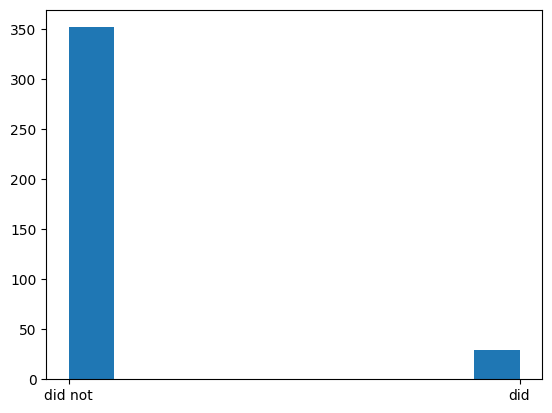

In [165]:
plt.hist(thoughtless_prediction)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

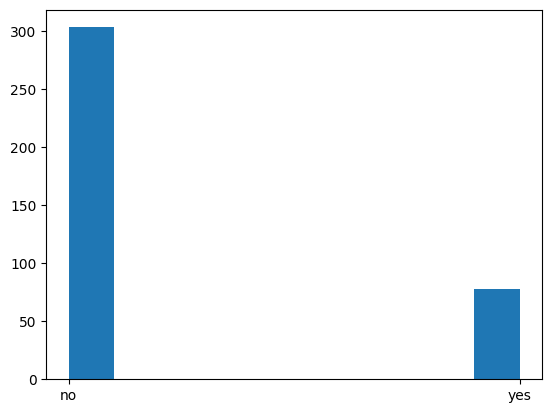

In [164]:
plt.hist(after_deadline)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

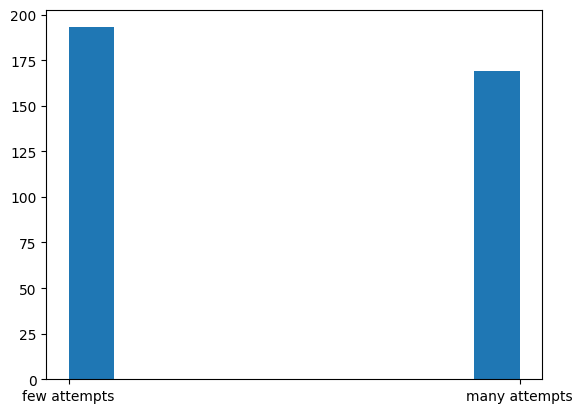

In [171]:
plt.hist(tests)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

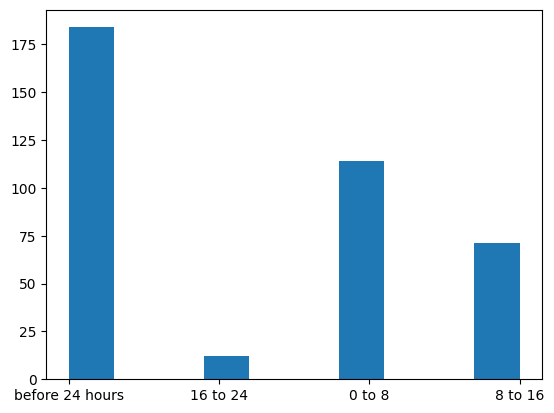

In [152]:
plt.hist(early_or_late_2)
plt.show

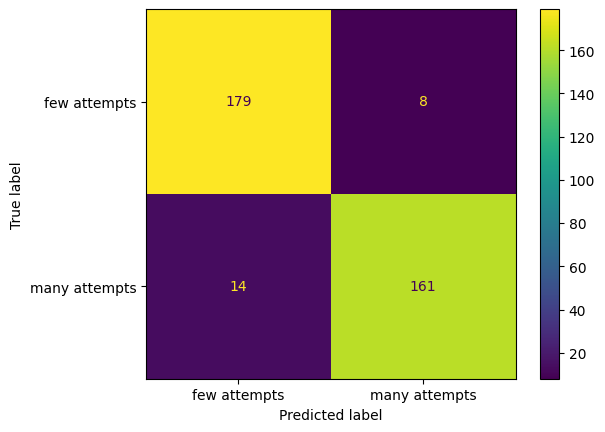

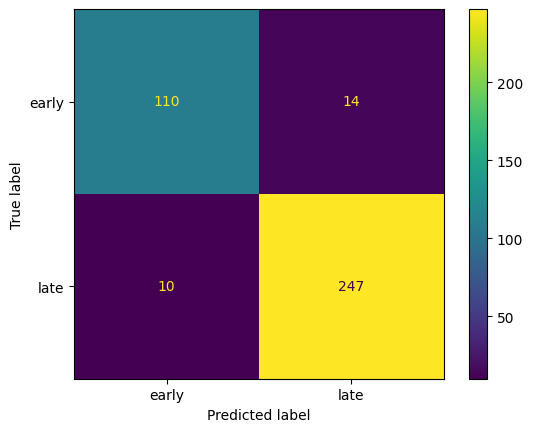

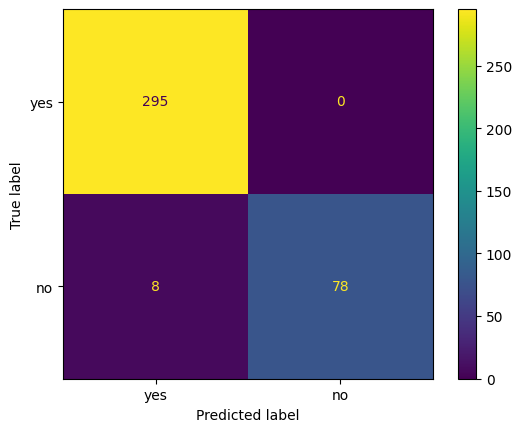

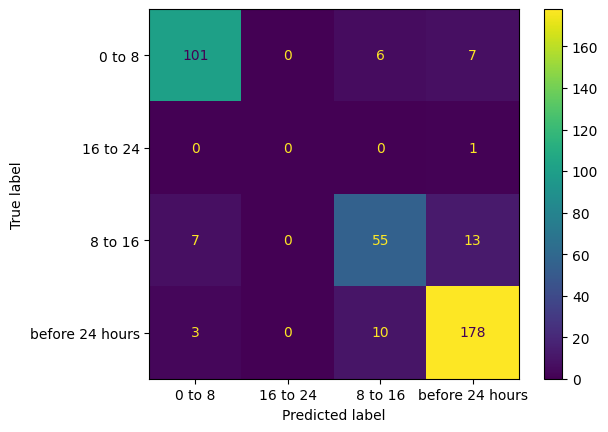

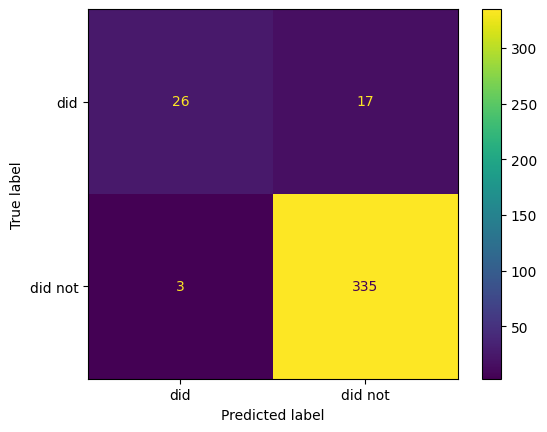

In [172]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(student_data_new_2021[['test profile']], tests)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['few attempts','many attempts'])
cm_display.plot()

confusion_matrix_2 = metrics.confusion_matrix(modified_log_2021[['early or late']], early_or_late)
cm_display_2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = ['early','late'])
cm_display_2.plot()

confusion_matrix_3 = metrics.confusion_matrix(late_tests_2021[['Did late tests']], after_deadline)
cm_display_3 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_3, display_labels = ['yes','no'])
cm_display_3.plot()

confusion_matrix_4 = metrics.confusion_matrix(modified_log_2_2021[['time of first test']], early_or_late_2)
cm_display_4 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_4, display_labels = ['0 to 8', '16 to 24', '8 to 16', 'before 24 hours'])
cm_display_4.plot()

confusion_matrix_5 = metrics.confusion_matrix(best_and_average_scores_difference_2021[['thoughtless_tests']], thoughtless_prediction)
cm_display_5 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_5, display_labels = ['did',"did not"])
cm_display_5.plot()

plt.show()